# Instragram Data Visualization

In [1]:
# data vis imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# data load imports
import requests
import json

%matplotlib inline

In [2]:
# username of Instragram user you want to run the script on
USERNAME = 'radikahl'

# Google Maps key. Needed to translate location names into Geo positions
MAPS_API_KEY = 'YOUR_KEY'

# Google Maps' API endpoint
MAPS_API_URL = 'https://maps.googleapis.com/maps/api/geocode/json?address={0}&key={1}'

# Instagram's API endpoint
INSTAGRAM_URL = 'http://instagram.com/{0}/media'

# data dumps
json_file = 'data/instagram_posts.json'
csv_file = 'data/instagram_posts.csv'

# Graph Config
title_fontsize = 16

## Pull Data from Instagram

In [3]:
def extractDataFromInstagram(username):
    data = []
    max_id = None
    more_available = True

    while more_available:
        url = INSTAGRAM_URL
        
        if max_id is not None:
            url += '?max_id=' + max_id
            
        response = requests.get(url.format(username))
        media = response.json()
        data.append(media)
        
        numAllPosts = len(data)
        numAllPosts = sum(len(s['items']) for s in data)
        if max_id is None:
            print('Loaded', end=' ')

        print(numAllPosts, end=' ')
        
        more_available = False
        if 'more_available' in media and media['more_available'] is True:
            max_id = media['items'][-1]['id']
            more_available = True

    return data

data = extractDataFromInstagram(USERNAME)

Loaded 20 40 60 80 100 115 

In [4]:
with open(json_file, 'w') as f:
    f.write(json.dumps(data, indent=2))

## Load Data into Dataframe

In [5]:
def loadDataIntoDataFrame(media):
    id,link,type,creation_time,likes,comments,location,body = [],[],[],[],[],[],[],[]
    for item in media['items']:
        #print(item['link'], item['type'])
        id.append(item['id'])
        link.append(item['link'])
        type.append(item['type'])
        creation_time.append(item['created_time'])
        likes.append(item['likes']['count'])
        comments.append(item['comments']['count'])
        if item['location'] is not None:
            location.append(item['location']['name'])
        else:
            location.append(np.nan)
        if item['caption'] is not None:
            body.append(item['caption']['text'])
        else:
            body.append('')

    df = pd.DataFrame(data = [id,link,type,creation_time,likes,comments,location,body]).T
    df.columns = ['id','link','type','creation_time','likes','comments','location','body']
    df = df.set_index('id')
    df['type'] = df['type'].astype('category', categories=['image', 'video'])
    df['creation_time'] = pd.to_datetime(df['creation_time'].astype(int), unit='s')
    df[['likes', 'comments']] = df[['likes', 'comments']].astype(int)
    
    return df

In [6]:
df = pd.DataFrame()
for chunk in data:
    df = df.append(loadDataIntoDataFrame(chunk))

In [7]:
# save dataframe as csv
df.to_csv(csv_file, index=False, encoding='utf-8')

## Vizualize Instragram Post Data

### Posts by Day of Week

In [8]:
df['weekday'] = df['creation_time'].dt.weekday

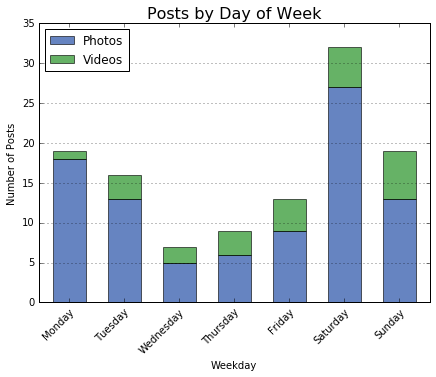

In [9]:
weekday_group = df[['weekday', 'type', 'link']].groupby(['weekday','type']).count()

weekday_group.index = weekday_group.index.set_levels(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    level=0)

plot = weekday_group.unstack().plot(kind='bar', stacked=True, figsize=[7, 5], 
                                    width=0.6, alpha=0.6, color=['#003399', 'g'],
                                    edgecolor='k', grid=False)
plot.set_title('Posts by Day of Week', fontsize=title_fontsize)
plot.set_xlabel("Weekday")
plot.set_ylabel("Number of Posts")
plot.legend(["Photos", "Videos"], loc=2, ncol=1)
plot.yaxis.grid(True)
plot.set_xticklabels(weekday_group.index.levels[0], rotation=45, 
                     rotation_mode='anchor', ha='right')

plt.savefig('images/instagram_posts_weekday.png', dpi=96, bbox_inches='tight')
plt.show()